## Transmitter Code

In [1]:
# Import all needed modules

import numpy as np
import scipy

from matplotlib import pyplot as plt
import random

from py import ldpc # LDPC from Jossy

In [2]:
# Define OFDM parameters:

symbol_length = 4096
cyclic_length = 1034

In [3]:
# Find LDPC Information

c = ldpc.code(standard = '802.16', rate = '1/2', z=54)

# print("LDPC PARAMETERS\n===============")

# print("Info length: ", c.K)
# print("Codeword length: ", c.N)

# print(c.Nmsg,  "number of messages")
# print(c.vdeg,  "variable node degrees")
# print(c.cdeg,  "constraint node degrees")
# print(c.intrlv,  "code interleaver")
# print(c.standard,  "IEEE standard")
# print(c.rate, "(code rate string)")
# print(c.z,  "z parameter of IEEE standard")
# print(c.ptype,  "code type for 802.16 rate 2/3 and 3/4")
# print(c.proto,  "proto (protograph")

In [4]:
# OPEN FILE TO TRANSMIT

with open('max_test_in.txt', 'r') as file:
    data = file.read().replace('\n', '')

binary_data = ''.join(format(ord(x), 'b').zfill(8) for x in data)
# binary_data = binary_data[0:(symbol_length//2 - 1) * 10] # Limit to 10 symbols
print(len(binary_data))
print(binary_data[0:128])

82648
01000001011000110110001101101111011100100110010001101001011011100110011100100000011101000110111100100000011000010110110001101100


0100000101100011011000110110111101110010011001000110100101101110011001110010000001110100011011110010000001100001011011000110110000100000011010110110111001101111011101110110111000100000011011000110000101110111011100110010000001101111011001100010000001100001011101100110100101100001011101000110100101101111011011100010110000100000011101000110100001100101011100100110010100100000011010010111001100100000011011100110111100100000011101110110000101111001001000000110000100100000011000100110010101100101001000000111001101101000011011110111010101101100011001000010000001100010011001010010000001100001011000100110110001100101001000000111010001101111001000001010000000101011101100000001000100010111001001001111110100110001111101001110100011010111110100000110010101000001110001010010010100100101011000101110110101100011100000101110100001101000111110011111000110010010010101111011110100001001001010100110101100100000011111001101101010010111001100000001001011100101011000010000110001111000110010100101110111100101

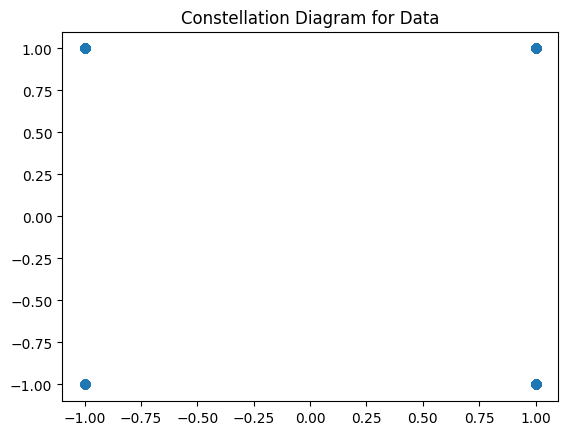

In [20]:
# LDPC ENCODING
if len (binary_data) % c.K != 0:
    binary_data += "0" * (c.K - (len(binary_data) % c.K))

to_ldpc = [binary_data[i:i+c.K] for i in range(0, len(binary_data), c.K)]

coded_binary_data = ''

for i in to_ldpc:
    assert len(i) == c.K

    ldpc_out = c.encode([int(i[k]) for k in range(0, len(i))]) # Needs to convert i to a list of binary numbers

    ldpc_out = ldpc_out.astype('str')

    coded_binary_data += ''.join(ldpc_out)

print(coded_binary_data)
print(len(coded_binary_data))

# coded_binary_data = binary_data # Disable ('undo') LDPC Coding

"""check = [coded_binary_data[i:i+c.N] for i in range(0, len(coded_binary_data), c.N)] # TESTING LDPC DECODING
print(len(check))
print(len(check[0]))
all_decoded = ''
for i in check:
    convert_to_list = np.array([int(i[k]) for k in range(0, len(i))])
    #convert_to_list = 1.4 - convert_to_list * 2.8 # ldpc decoder needs values around 0, not around 0.5
    #convert_to_list[10] = -convert_to_list[10] # Flip one bit to test if it works
    #decoded, iter = c.decode(convert_to_list, 'sumprod2') # Needs to convert i to a list of binary numbers
    print(iter)
    decoded = decoded[0:c.K]
    print(decoded)
    decoded = ''.join(['0' if j > 0 else '1' for j in decoded])
    #decoded = decoded.astype('str')
    all_decoded += ''.join(decoded)"""
"""print(all(all_decoded))
print(len(binary_data))
assert len(all_decoded) == len(binary_data)
print(all_decoded[0], binary_data[0])
print(all_decoded[1], binary_data[1])
print(all_decoded[2], binary_data[2])
print(all_decoded[3], binary_data[3])
print(all_decoded[10], binary_data[10])
assert all_decoded == binary_data"""
# PAD WITH 0s to match OFDM symbols

split_length = symbol_length - 2 # (symbol_length - 2) as need 511 constellation 'stars' per symbol, and each 'star' represents 2 bits.

# for i in range(split_length - (len(binary_data) % split_length)): 
#     binary_data += "0"
# coded_binary_data = binary_data
ofdm_padding_length = split_length - (len(coded_binary_data) % split_length)

coded_binary_data += "0" * ofdm_padding_length

assert len(coded_binary_data) % split_length == 0.0

print(len(coded_binary_data))

# ENCODE WITH GRAY CODE

to_encode = [coded_binary_data[i:i+2] for i in range(0, len(coded_binary_data), 2)] # Split into list of two characters elements

gray_code = 1j * np.arange(len(to_encode)) # 'empty' array

for index, i in enumerate(to_encode):
    if i == "00":
        gray_code[index] = 1 + 1j
    elif i == "01":
        gray_code[index] = -1 + 1j
    elif i == "11":
        gray_code[index] = -1 - 1j
    elif i == "10":
        gray_code[index] = 1 - 1j
    else:
        print(i)
        raise Exception("Gray code mapping error")

plt.scatter(gray_code[0:500].real, gray_code[0:500].imag)
print(gray_code.shape)
plt.title("Constellation Diagram for Data")
plt.show()

# gray_code is one list of all the gray code points

In [22]:
symbols = np.split(np.array(gray_code), len(gray_code) / (split_length / 2))
print(symbols[0].shape)

# ENFORCE CONJUGATE SYMMETRY:

for index, x in enumerate(symbols):
    conj = np.conjugate(x)[::-1]
    symbols[index] = np.concatenate((x, conj), axis=None) # Add reflected conjugate symmetry

    symbols[index] = np.insert(symbols[index], 0, 0)
    symbols[index] = np.insert(symbols[index], int(symbol_length / 2), 0)

# Inverse DFT
print(symbols[0])
info = np.fft.ifft(symbols)

for i in info[5]:
    assert i.imag == 0 # Check is now real

# ADD CYCLIC PREFIXES

to_transmit = np.zeros(shape = (len(info), symbol_length + cyclic_length))

for index, x in enumerate(info):
    cyclic_prefix = x[-cyclic_length:]
    new_x = np.concatenate((cyclic_prefix, x), axis = None)
    to_transmit[index] = new_x

print(to_transmit.shape) # Should be (319 - or alternate length, 1056)

to_transmit = np.concatenate(to_transmit, axis = 0)

print(to_transmit.shape)

print(to_transmit)
print(len(to_transmit))

(2047,)
[ 0.+0.j -1.+1.j  1.+1.j ...  1.-1.j  1.-1.j -1.-1.j]
(41, 5130)
(210330,)
[-0.00878733  0.00529538 -0.03766934 ...  0.16183773 -0.26048869
  0.08985343]
210330


/var/folders/10/m2d64f1s1kx01s59h9vnf84w0000gn/T/ipykernel_17014/3802833208.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  to_transmit[index] = new_x


## Channel Simulation

In [7]:
# CHANNEL FILTER

channel_response = np.loadtxt('../weekend_files/channel.csv', delimiter = ",", dtype = "float")

to_decode = np.convolve(channel_response, to_transmit)

to_decode = to_decode[:-1 * len(channel_response) + 1]

# NOISE

for index, i in enumerate(to_decode):
    to_decode[index] = i + random.gauss(0.0, 0.005)

np.savetxt("max_test_out.csv", to_decode, delimiter = ",")


## Decoder

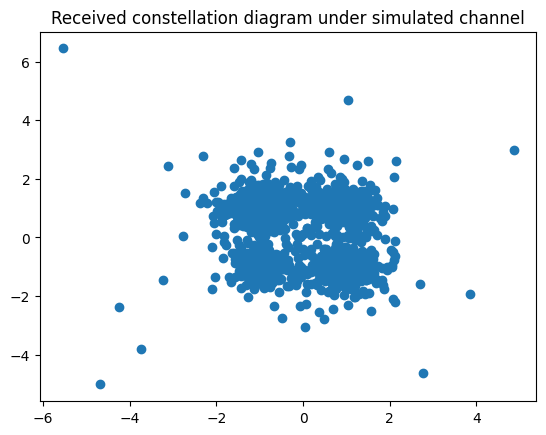

In [8]:
decoded_symbols = np.split(to_decode, len(to_decode) / (symbol_length + cyclic_length))

# Remove Cyclic Prefix

for index, i in enumerate(decoded_symbols):
    decoded_symbols[index] = i[cyclic_length:]

# DFT each symbol:

symbols_freq = np.zeros((len(decoded_symbols), symbol_length)).astype(complex) # 'empty' array

for index, i in enumerate(decoded_symbols):
    symbols_freq[index] = np.fft.fft(i)

assert symbols_freq.shape[1] == symbol_length

channel_response = np.pad(channel_response, (0, symbol_length - len(channel_response)))
channel_freq = np.fft.fft(channel_response)

# Divide by DFT of Channel Response:

recieved_freq = symbols_freq / channel_freq

constellations = recieved_freq[0][1:2048]

for index, i in enumerate(recieved_freq[1:]):
    constellations = np.vstack((constellations, i[1:2048]))

plt.scatter(constellations[10].real, constellations[10].imag)
plt.title("Received constellation diagram under simulated channel")
plt.show()


In [9]:
decoded_binary = []

# Do Inverse Gray Code:

for symbol in constellations:
    for i in symbol:
        if np.real(i) >= 0 and np.imag(i) >= 0:
            decoded_binary.append("00")
        elif np.real(i) <= 0 and np.imag(i) >= 0:
            decoded_binary.append("01")
        elif np.real(i) <= 0 and np.imag(i) <= 0:
            decoded_binary.append("11")
        elif np.real(i) >= 0 and np.imag(i) <= 0:
            decoded_binary.append("10")
        else:
            raise Exception("Gray Code Decoding Error")

decoded_binary = ''.join(decoded_binary)
success = 0
fail = 0
print(len(binary_data))

decoded_binary_no_padding = decoded_binary[:-ofdm_padding_length]
print(len(decoded_binary_no_padding))
for index, i in enumerate(decoded_binary_no_padding[:385056]):
    if i == binary_data[index]:
        success += 1
    else:
        fail += 1
        print(index, i, binary_data[index])
print(success / (success + fail))

82944
82944
252 1 0
307 1 0
863 1 0
879 1 0
887 0 1
897 0 1
899 1 0
910 1 0
911 0 1
920 1 0
925 1 0
929 0 1
934 1 0
935 0 1
936 1 0
938 0 1
955 1 0
956 1 0
964 1 0
991 1 0
1007 0 1
1011 0 1
1306 0 1
1337 0 1
1348 1 0
1355 1 0
1366 1 0
1367 1 0
1371 1 0
1379 1 0
1384 1 0
1385 0 1
1392 1 0
1397 0 1
1398 1 0
1399 0 1
1403 0 1
1404 1 0
1405 1 0
1410 0 1
1414 1 0
1416 1 0
1419 1 0
1420 1 0
1421 1 0
1422 1 0
1424 1 0
1434 0 1
1437 1 0
1438 1 0
1439 0 1
1441 0 1
1449 0 1
1459 0 1
1463 0 1
1464 1 0
1473 0 1
1517 1 0
1889 0 1
1897 0 1
1898 0 1
1900 0 1
1907 1 0
1908 1 0
1918 0 1
3194 0 1
3614 0 1
3651 1 0
3716 1 0
3735 1 0
3762 0 1
3784 1 0
3912 1 0
4017 1 0
4342 0 1
4367 1 0
4402 0 1
4966 0 1
4974 1 0
4975 0 1
4978 0 1
4987 1 0
4993 0 1
5000 1 0
5005 0 1
5011 1 0
5016 1 0
5019 1 0
5031 0 1
5033 0 1
5051 1 0
5062 1 0
5072 1 0
5082 0 1
5390 0 1
5432 1 0
5446 0 1
5455 0 1
5460 0 1
5461 0 1
5463 0 1
5465 0 1
5470 1 0
5475 1 0
5477 1 0
5488 1 0
5494 0 1
5498 0 1
5502 1 0
5504 1 0
5508 1 0
5509 1 0


In [10]:
# Remove OFDM Padding:

# TODO find OFDM Padding length automatically

# assert decoded_binary[-ofdm_padding_length:] == ("0" * ofdm_padding_length) # No idea why this doesn't work...

decoded_binary_no_padding = decoded_binary[:-ofdm_padding_length]

# LDPC DECODING

# Split into c.N lengths

to_ldpc_decoder = np.array([decoded_binary_no_padding[i:i+c.N] for i in range(0, len(decoded_binary_no_padding), c.N)])

for i in to_ldpc_decoder:
    assert len(i) == c.N

# Decode each section

binary_ldpc_out = ''

for i in to_ldpc_decoder[0:]:

    convert_to_list = np.array([int(i[k]) for k in range(0, len(i))])
    convert_to_list = 10 * (0.5 - convert_to_list) # ldpc decoder needs values around 0, not around 0.5

    ldpc_out, iter = c.decode(convert_to_list) # Needs to convert i to a list of binary numbers

    ldpc_out = ldpc_out[0 : c.K] # NO IDEA WHAT ldpc_out CONTAINS AFTER c.K ?? Why is it the same size as the codewords?

    binary_ldpc_out += ''.join(['0' if j > 0 else '1' for j in ldpc_out])


In [24]:
# CONVERT BINARY TO ASCII

# binary_ldpc_out = decoded_binary # Disable LDPC

success = 0
fail = 0

print(binary_ldpc_out)
print(type(binary_ldpc_out))
print(len(binary_data))

for index, i in enumerate(binary_ldpc_out[:385056]):
    if i == binary_data[index]:
        success += 1
    else:
        fail += 1
        print(index, i, binary_data[index])
print(success / (success + fail))

# Split into 7 bit sections:

decoded_text = ''

ascii = [int(binary_ldpc_out[i:i+8], 2) for i in range(0, len(binary_ldpc_out), 8)]
decoded_text_list = [chr(i) for i in ascii]

decoded_text = ''.join([chr(i) for i in ascii])


f = open("max_test_out.txt", "w")
f.write(decoded_text)
f.close()

g = open("max_test_in.txt", "w")
g.write(data)
g.close()

0000000101110011001000110010111101010000110001000110110101100110011001110010000001110101011010110010100001100011001011000110110001101100011010110111100001101101001100110110111000100000010011000110000111100111011100110010001001101111011001110010000001101001010101000110100101100001011101000010000011101111011111100010100000101100111101000110000001101101011100100010010100100000011010010100000000100000001011100010011100100000011001111111000101111011011000010110000100100010011010000110010101100101000010000111001101101000010111110111000101011100011001000010000001100010011001010000000011100011011000100110110101101101001000110111010011101111101000000110000001000011011011100110011101110010001100110110110110111100001000110111011001111100101010011110001101101111000100101111011111001100010111100011011100001000011010001010000000100010011001010110001101100001011101010101011100100101001010000110001001100101011001010001000100101000011001100110111111101110001001110111010001100000011000110110100101110010